<a href="https://colab.research.google.com/github/khojwar/Master_Thesis/blob/main/12_(Improve3_Breakthrough_second_success_another_experiment)_pos_tagging_using_lstm_without_loosing_sentence_sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install tensorflow
# !pip install --upgrade gensim

In [2]:
import os
import xml.etree.ElementTree as ET
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences  # Update this line
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, TimeDistributed, Dropout  # Update this line

import nltk
from nltk.tokenize import word_tokenize

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# authenticate and mount the Google Drive
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Chage directory to project folder
%cd /content/drive/MyDrive/Nepali POS Tagging/
%ls

/content/drive/MyDrive/Nepali POS Tagging
 002_Nepali_pos_tagging_SVM.ipynb
'003_(first_success)_pos_tagging_using_word2Vec_and_LSTM.ipynb'
'006_( To_Improve4_first_success)_pos_tagging_using_word2Vec_and_GRU_LSTM_BiLSTM.ipynb'
'11_(Improve2_Breakthrough_second_success_another_experiment)_pos_tagging_using_lstm_without_loosing_sentence_sentiment.ipynb'
 2_nnc_updated_ah/
 nnc_updated_ah/
 trained_model/


# Access the book directory's xml files and create tagsets list

In [5]:
# Set the path to the directory containing XML files
path = '2_nnc_updated_ah/gc/books/'
filelist = os.listdir(path)
filelist

['book-academic-jana-siksha-2058.xml',
 'book-academic-swasthya-samaj-ra-rajniti-2062.xml',
 'book-autobiography-mero-aviral-jivangit-2060.xml',
 'book-academic-rupantaran-2062.xml',
 'book-anthropology-sabai-jatko-fulbari-2055.xml']

In [6]:
tagsets = []

for file in filelist:
    filepath = os.path.join(path, file)
    # print(filepath)

    tree = ET.parse(filepath)   # Parse an XML file and create an ElementTree object
    root = tree.getroot()   # Get the root element of the XML document
    # print(root)

    # Find all "w" elements with a "ctag" attribute
    word_elements = root.findall(".//w[@ctag]")

    # Extract POS tags
    tagset = [word.attrib["ctag"] for word in word_elements]
    tagsets.extend(tagset)


# plot the code

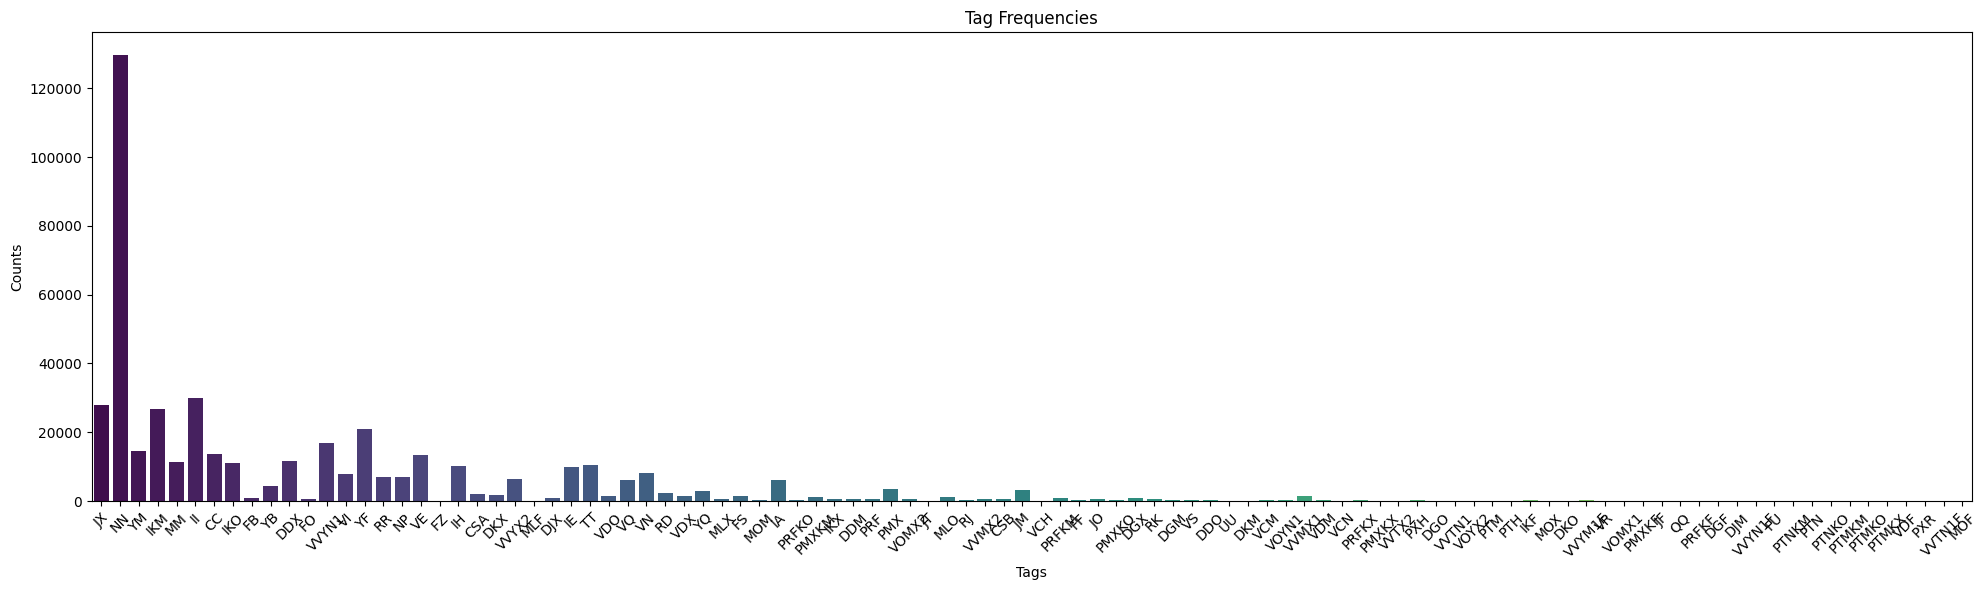

In [7]:
from collections import Counter
import pandas as pd

# Count the occurrences of each tag
tag_counts = Counter(tagsets)

# Convert the tag_counts to a DataFrame for Seaborn plotting
tag_df = pd.DataFrame.from_dict(tag_counts, orient='index', columns=['Count']).reset_index()
tag_df.rename(columns={'index': 'Tag'}, inplace=True)

# Create a bar plot using Seaborn
plt.figure(figsize=(20, 6))
sns.barplot(x='Tag', y='Count', data=tag_df, palette='viridis')
plt.xlabel('Tags')
plt.ylabel('Counts')
plt.title('Tag Frequencies')
plt.xticks(rotation=45)
plt.tight_layout()

# Display the plot
plt.show()

# step 1:  Extract sentences and pos_tags from xml file

In [8]:
def parse_xml(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    sentences = []
    pos_tags = []
    for sentence in root.findall('.//s'):
        words = []
        tags = []
        for word_elem in sentence.findall('./w'):
            words.append(word_elem.text)
            tags.append(word_elem.get('ctag'))
        sentences.append(words)
        pos_tags.append(tags)
    return sentences, pos_tags

In [9]:
all_sentences = []
all_pos_tags = []

for file in filelist:
    filepath = os.path.join(path, file)
    # print(filepath)

    # file_path = "book-academic-jana-siksha-2058.xml"
    sentences, pos_tags = parse_xml(filepath)
    all_sentences += sentences
    all_pos_tags += pos_tags

# Step 2: Word Embedding with word2vec

In [10]:
# created a Word2Vec model using Gensim in Python
from gensim.models import Word2Vec

def train_word2vec(sentences, embedding_dim=100):
    model = Word2Vec(sentences, vector_size=embedding_dim, window=5, min_count=1, workers=4)
    return model

In [11]:
# Step 2: Word Embedding with word2vec
embedding_model = train_word2vec(all_sentences)
# embedding_model.wv.key_to_index

# Step 3: Preprocessing

In [12]:
# Create vocabulary and POS tag mapping
vocab = set([word for sentence in all_sentences for word in sentence])
pos_tags_set = set([tag for tags in all_pos_tags for tag in tags])
word_to_idx = {word: idx + 1 for idx, word in enumerate(vocab)}
tag_to_idx = {tag: idx for idx, tag in enumerate(pos_tags_set)}
idx_to_tag = {idx: tag for tag, idx in tag_to_idx.items()}

In [ ]:
# Add the "UNK" token to your vocabulary
# word_to_idx["UNK"] = len(word_to_idx) + 1

In [13]:
# Convert words and tags to indices
sentences_indices = [[word_to_idx[word] for word in sentence] for sentence in all_sentences]
pos_tags_indices = [[tag_to_idx[tag] for tag in tags] for tags in all_pos_tags]


In [14]:
# Pad sequences
max_sequence_length = max([len(seq) for seq in sentences_indices])
sentences_indices_padded = pad_sequences(sentences_indices, maxlen=max_sequence_length)
pos_tags_indices_padded = pad_sequences(pos_tags_indices, maxlen=max_sequence_length)


# Step 4: Splitting dataset into 70% train, 15% val, and 15% test

In [15]:
# Splitting data into 70% train, 30% temp
sentences_train, sentences_temp, pos_tags_train, pos_tags_temp = train_test_split(sentences_indices_padded, pos_tags_indices_padded, test_size=0.3, random_state=42)

# Splitting temp data into 50% val and 50% test
sentences_val, sentences_test, pos_tags_val, pos_tags_test = train_test_split(sentences_temp, pos_tags_temp, test_size=0.5, random_state=42)

# Step 5: Build the LSTM model

In [16]:
# Build the LSTM model
model = Sequential()
model.add(Embedding(input_dim=len(word_to_idx) + 1, output_dim=300, input_length=max_sequence_length))    # (number of unique words, 300-dimensional vector)
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.3))  # Adding a dropout layer with 30% dropout rate
model.add(Dense(64, activation='relu'))  # Adding an additional dense layer
model.add(TimeDistributed(Dense(len(tag_to_idx), activation='softmax')))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 303, 300)          9916800   
                                                                 
 lstm (LSTM)                 (None, 303, 128)          219648    
                                                                 
 dropout (Dropout)           (None, 303, 128)          0         
                                                                 
 dense (Dense)               (None, 303, 64)           8256      
                                                                 
 time_distributed (TimeDistr  (None, 303, 100)         6500      
 ibuted)                                                         
                                                                 
Total params: 10,151,204
Trainable params: 10,151,204
Non-trainable params: 0
____________________________________________

`(None, 303, 300)` represents the shape of the input and output of this embedding layer. Here, None indicates that the batch size can vary, 303 is the sequence length of each input, and 300 is the dimensionality of the embedding vector.

# Step 6: Compile the model

In [17]:
from tensorflow.keras.optimizers import Adam

model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.01), metrics=['accuracy'])

# Step 7: Train the LSTM model with Train and val dataset

In [31]:
# Train the model
history = model.fit(sentences_train, pos_tags_train, epochs=10, batch_size=128, validation_data=(sentences_val, pos_tags_val), verbose=1)

Epoch 1/10
126/126 [==============================] - 309s 2s/step - loss: 0.2192 - accuracy: 0.9613 - val_loss: 0.0305 - val_accuracy: 0.9930
Epoch 2/10
126/126 [==============================] - 391s 3s/step - loss: 0.0201 - accuracy: 0.9954 - val_loss: 0.0130 - val_accuracy: 0.9973
Epoch 3/10
126/126 [==============================] - 309s 2s/step - loss: 0.0084 - accuracy: 0.9980 - val_loss: 0.0124 - val_accuracy: 0.9977
Epoch 4/10
126/126 [==============================] - 341s 3s/step - loss: 0.0055 - accuracy: 0.9987 - val_loss: 0.0119 - val_accuracy: 0.9979
Epoch 5/10
126/126 [==============================] - 301s 2s/step - loss: 0.0043 - accuracy: 0.9989 - val_loss: 0.0134 - val_accuracy: 0.9979
Epoch 6/10
126/126 [==============================] - 301s 2s/step - loss: 0.0037 - accuracy: 0.9991 - val_loss: 0.0137 - val_accuracy: 0.9980
Epoch 7/10
126/126 [==============================] - 301s 2s/step - loss: 0.0033 - accuracy: 0.9992 - val_loss: 0.0144 - val_accuracy: 0.9978

# Step 8: Create a plot of accuracy and loss over time
model.fit() returns a History object that contains a dictionary with everything that happened during training:

In [ ]:
# history_dict = history.history
# history_dict.keys()

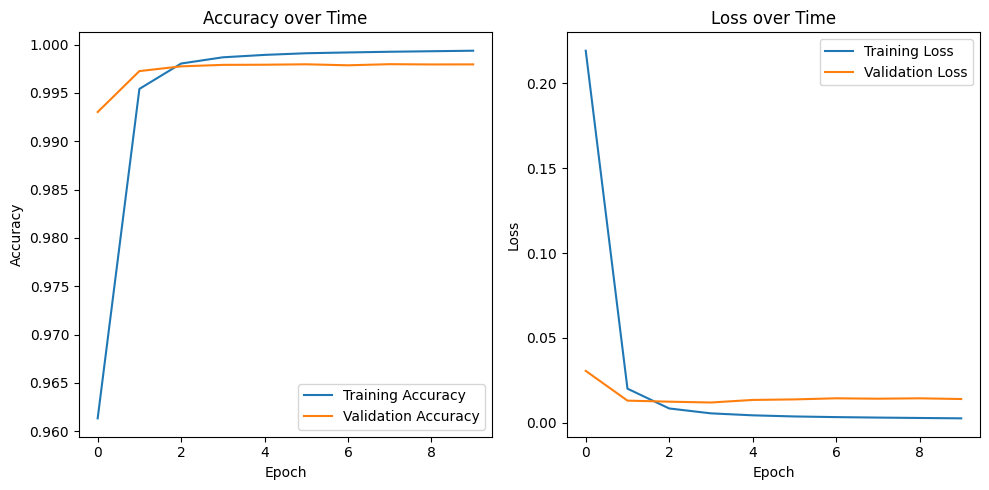

In [32]:
import matplotlib.pyplot as plt


# Plot accuracy over time
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Time')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss over time
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Step 9: Save the trained model

In [33]:
# Save the trained model
model.save("/content/drive/MyDrive/Nepali POS Tagging/trained_model/2_LSTM/")

# Step 10: Load the trained model

In [18]:
from keras.models import load_model

# Load the trained model
LSTM_model = load_model("/content/drive/MyDrive/Nepali POS Tagging/trained_model/2_LSTM/")

# Step 11: Evaluate the model

In [35]:
# Evaluate the model
loss, accuracy = model.evaluate(sentences_test, pos_tags_test, verbose=1)
print("Loss: {0},\nAccuracy: {1}".format(loss, accuracy))

108/108 [==============================] - 26s 238ms/step - loss: 0.0136 - accuracy: 0.9980
Loss: 0.013566898182034492,
Accuracy: 0.99796462059021


# Step 12: Plot the confusion matrix using Seaborn

108/108 [==============================] - 27s 247ms/step


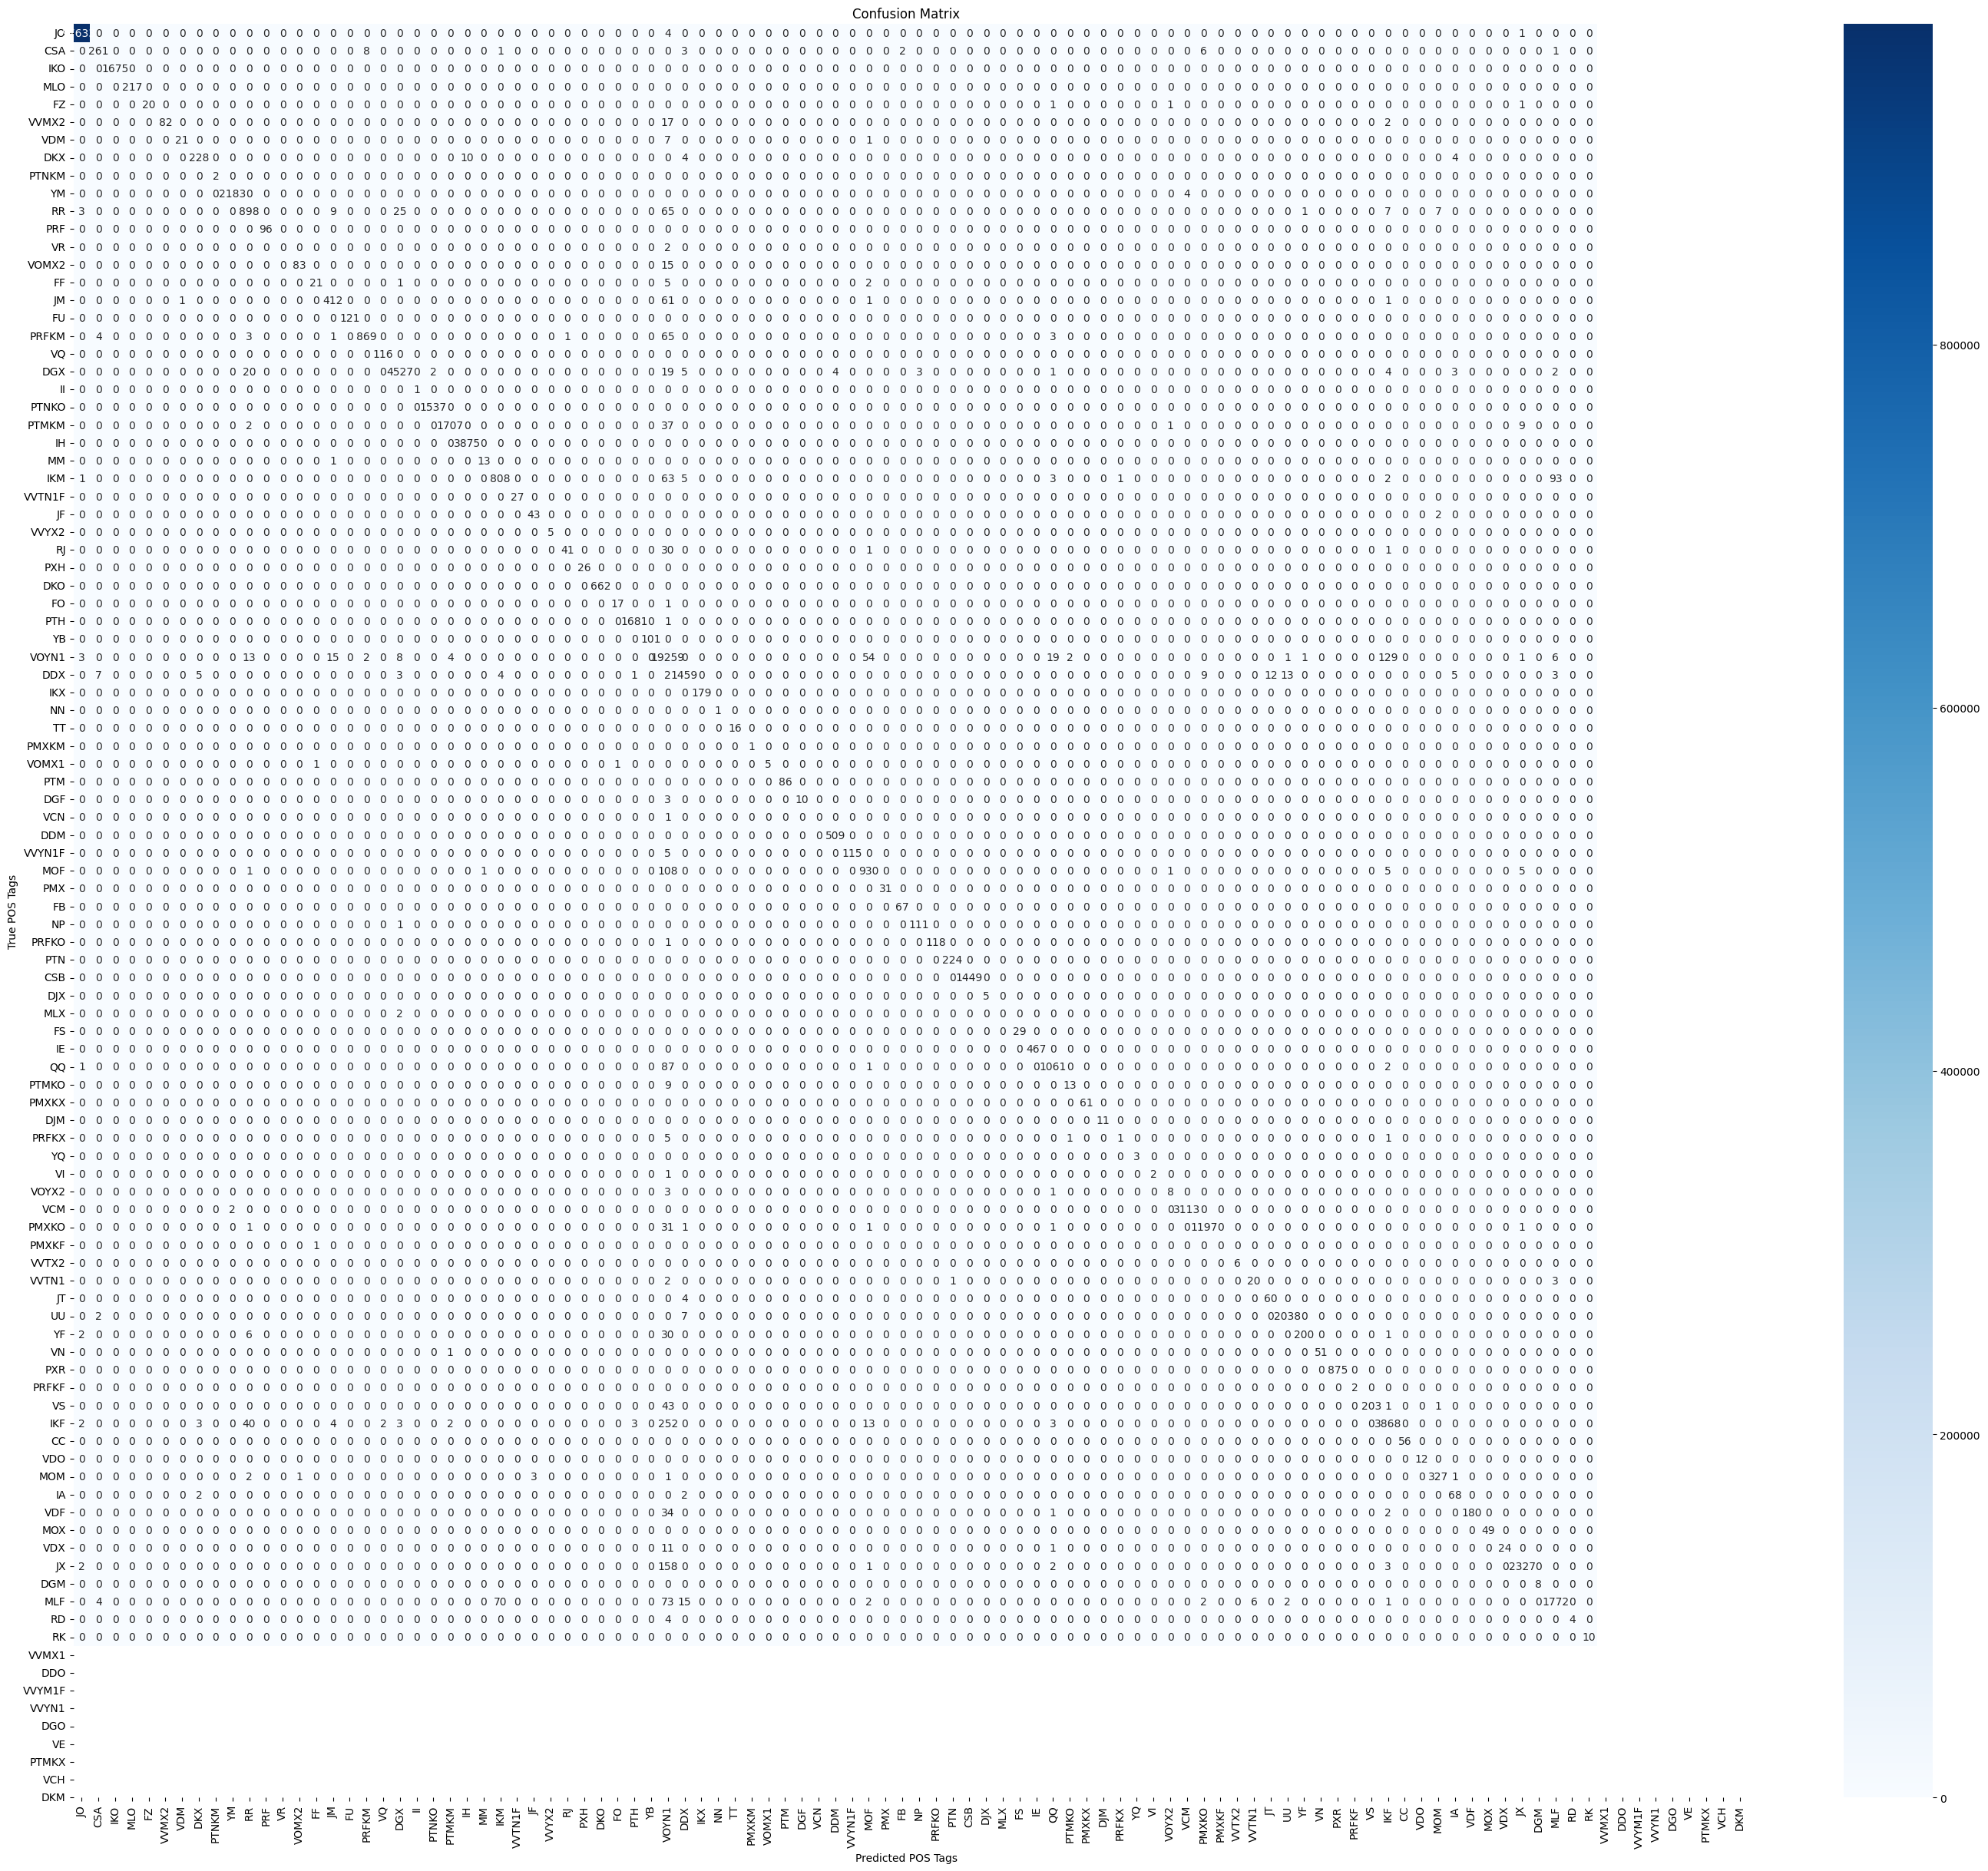

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Predict POS tags using the trained model
predicted_tags = model.predict(sentences_test)
predicted_tags = np.argmax(predicted_tags, axis=-1)

# Flatten the true and predicted tags arrays
true_tags_flat = np.ravel(pos_tags_test)
predicted_tags_flat = np.ravel(predicted_tags)

# Create a confusion matrix
confusion_mat = confusion_matrix(true_tags_flat, predicted_tags_flat)

# Plot the confusion matrix using Seaborn
plt.figure(figsize=(35, 30))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', xticklabels=idx_to_tag.values(), yticklabels=idx_to_tag.values())
plt.xlabel('Predicted POS Tags')
plt.ylabel('True POS Tags')
plt.title('Confusion Matrix')
plt.show()


# Step 13: Calculate precision, recall, F1 score and accuracy

In [38]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Calculate precision, recall, and F1 score
precision = precision_score(true_tags_flat, predicted_tags_flat, average='weighted')
recall = recall_score(true_tags_flat, predicted_tags_flat, average='weighted')
f1 = f1_score(true_tags_flat, predicted_tags_flat, average='weighted')

# Calculate accuracy
accuracy = accuracy_score(true_tags_flat, predicted_tags_flat)

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Accuracy: {accuracy:.4f}')


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision: 0.9980
Recall: 0.9980
F1 Score: 0.9979
Accuracy: 0.9980


In [39]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [40]:
from nltk.tokenize import word_tokenize

# Take user input sentence
new_sentence = input("Enter a sentence: ")
tokenized_new_sentence = word_tokenize(new_sentence.lower())
new_sentence_indices = [word_to_idx.get(word, 0) for word in tokenized_new_sentence]  # Use 0 if word is not in vocabulary

# Pad the input sequence to match the model's input length
padded_new_sentence_indices = pad_sequences([new_sentence_indices], maxlen=max_sequence_length, padding='post', value=0)

# Predict POS tags for the input sentence
predicted_tag_indices = model.predict(padded_new_sentence_indices)
predicted_tags = [idx_to_tag[idx] for idx in np.argmax(predicted_tag_indices, axis=-1)[0]]

# Print the POS tagged sentence
pos_tagged_sentence = list(zip(tokenized_new_sentence, predicted_tags))
for word, pos_tag in pos_tagged_sentence:
    print(f'{word}: {pos_tag}')


Enter a sentence: राम लेख लेख ।
1/1 [==============================] - 0s 62ms/step
राम: NP
लेख: NN
लेख: NN
।: YF


# Step 14: From the loaded model "LSTM_model"

In [44]:
from nltk.tokenize import word_tokenize

# Take user input sentence
new_sentence = input("Enter a sentence: ")
tokenized_new_sentence = word_tokenize(new_sentence.lower())
new_sentence_indices = [word_to_idx.get(word, 0) for word in tokenized_new_sentence]  # Use 0 if word is not in vocabulary

# Pad the input sequence to match the model's input length
padded_new_sentence_indices = pad_sequences([new_sentence_indices], maxlen=max_sequence_length, padding='post', value=0)

# Predict POS tags for the input sentence
predicted_tag_indices = LSTM_model.predict(padded_new_sentence_indices)
predicted_tags = [idx_to_tag[idx] for idx in np.argmax(predicted_tag_indices, axis=-1)[0]]

# Print the POS tagged sentence
pos_tagged_sentence = list(zip(tokenized_new_sentence, predicted_tags))
for word, pos_tag in pos_tagged_sentence:
    print(f'{word}: {pos_tag}')

Enter a sentence: नवनियुक्त प्रधानन्यायाधीश विश्वम्भरप्रसाद श्रेष्ठ ले शपथ लिए का छन् । राष्ट्रपति भवन शीतल निवास मा मंगलबार आयोजित एक समारोह मा राष्ट्रपति रामचन्द्र पौडेलसमक्ष श्रेष्ठ ले पद तथा गोपनियता को शपथ ग्रहण गरे का हुन् ।
1/1 [==============================] - 0s 49ms/step
नवनियुक्त: JO
प्रधानन्यायाधीश: JO
विश्वम्भरप्रसाद: JO
श्रेष्ठ: NP
ले: IE
शपथ: NN
लिए: VE
का: IKO
छन्: VVYX2
।: YF
राष्ट्रपति: NN
भवन: NN
शीतल: JX
निवास: NN
मा: II
मंगलबार: RR
आयोजित: JX
एक: MM
समारोह: NN
मा: II
राष्ट्रपति: NN
रामचन्द्र: NN
पौडेलसमक्ष: JO
श्रेष्ठ: NP
ले: IE
पद: NN
तथा: CC
गोपनियता: RR
को: IKM
शपथ: NN
ग्रहण: NN
गरे: VVYX2
का: IKO
हुन्: VVYX2
।: YF


In [45]:
from nltk.tokenize import word_tokenize
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Take user input sentence
new_sentence = input("Enter a sentence: ")
tokenized_new_sentence = word_tokenize(new_sentence.lower())
new_sentence_indices = [word_to_idx.get(word, word_to_idx["UNK"]) for word in tokenized_new_sentence]  # Use "UNK" if word is not in vocabulary

# Pad the input sequence to match the model's input length
padded_new_sentence_indices = pad_sequences([new_sentence_indices], maxlen=max_sequence_length, padding='post', value=word_to_idx["UNK"])

# Predict POS tags for the input sentence
predicted_tag_indices = LSTM_model.predict(padded_new_sentence_indices)
predicted_tags = [idx_to_tag[idx] for idx in np.argmax(predicted_tag_indices, axis=-1)[0]]

# Print the POS tagged sentence
pos_tagged_sentence = list(zip(tokenized_new_sentence, predicted_tags))
for word, pos_tag in pos_tagged_sentence:
    print(f'{word}: {pos_tag}')


Enter a sentence: राम लेख लेख ।


KeyError: ignored

In [47]:
from nltk.tokenize import word_tokenize
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Add the "UNK" token to your vocabulary
word_to_idx["UNK"] = len(word_to_idx) + 1

# Take user input sentence
new_sentence = input("Enter a sentence: ")
tokenized_new_sentence = word_tokenize(new_sentence.lower())
new_sentence_indices = [word_to_idx.get(word, word_to_idx["UNK"]) for word in tokenized_new_sentence]  # Use "UNK" if word is not in vocabulary

# Pad the input sequence to match the model's input length
padded_new_sentence_indices = pad_sequences([new_sentence_indices], maxlen=max_sequence_length, padding='post', value=word_to_idx["UNK"])

# Predict POS tags for the input sentence
predicted_tag_indices = LSTM_model.predict(padded_new_sentence_indices)
predicted_tags = [idx_to_tag[idx] for idx in np.argmax(predicted_tag_indices, axis=-1)[0]]

# Print the POS tagged sentence
pos_tagged_sentence = list(zip(tokenized_new_sentence, predicted_tags))
for word, pos_tag in pos_tagged_sentence:
    print(f'{word}: {pos_tag}')


Enter a sentence: राम लेख लेख ।


InvalidArgumentError: ignored

In [20]:
from nltk.tokenize import word_tokenize
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Add the "UNK" token to your vocabulary
word_to_idx["UNK"] = len(word_to_idx) + 1

# Take user input sentence
new_sentence = input("Enter a sentence: ")
tokenized_new_sentence = word_tokenize(new_sentence.lower())
new_sentence_indices = [word_to_idx.get(word, word_to_idx["UNK"]) for word in tokenized_new_sentence]  # Use "UNK" if word is not in vocabulary

# Ensure the indices in the new sentence align with vocabulary
aligned_indices = [idx if idx < len(word_to_idx) else word_to_idx["UNK"] for idx in new_sentence_indices]

# Pad the input sequence to match the model's input length
padded_new_sentence_indices = pad_sequences([aligned_indices], maxlen=max_sequence_length, padding='post', value=word_to_idx["UNK"])

# Predict POS tags for the input sentence
predicted_tag_indices = LSTM_model.predict(padded_new_sentence_indices)
predicted_tags = [idx_to_tag[idx] for idx in np.argmax(predicted_tag_indices, axis=-1)[0]]

# Print the POS tagged sentence
pos_tagged_sentence = list(zip(tokenized_new_sentence, predicted_tags))
for word, pos_tag in pos_tagged_sentence:
    print(f'{word}: {pos_tag}')


Enter a sentence: राम लेख लेख ।


InvalidArgumentError: ignored